In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import risk_toolkit as rtk
import re
%matplotlib inline
%load_ext autoreload
%autoreload 2
pd.set_option('display.float_format', lambda x: '%.5f' %x)
np.set_printoptions(suppress=True)
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [5]:
sheet_to_df_map = pd.read_excel('Fund_performance.xls', sheet_name=None, index_col = 0, header = 0, na_values = '--')
sheet_to_df_map_2 = sheet_to_df_map.copy()
del sheet_to_df_map_2['fund-performance']
dataset = pd.concat([value for _, value in sheet_to_df_map_2.items()], axis=1)

In [6]:
yearwise_ret = sheet_to_df_map['yearwise_ret']
snapshot = sheet_to_df_map['snapshot']
recent_ret = sheet_to_df_map['recent_ret']
nav = sheet_to_df_map['nav']
fund_mgr = sheet_to_df_map['fund_mgr']
quarterwise_ret = sheet_to_df_map['quarterwise_ret']

# Test Data Format

In [7]:
yearwise_ret.T['BNP Paribas Long Term Equity Fund - Direct Plan']

2011        nan
2012        nan
2013        nan
2014   53.34000
2015    8.43000
2016   -5.93000
2017   43.81000
2018   -8.23000
2019   15.59000
2020   19.24000
Name: BNP Paribas Long Term Equity Fund - Direct Plan, dtype: float64

In [8]:
rtk.compute_drawdown(yearwise_ret.T['BNP Paribas Long Term Equity Fund - Direct Plan']/100).Wealth

2011          nan
2012          nan
2013          nan
2014   1533.40000
2015   1662.66562
2016   1564.06955
2017   2249.28842
2018   2064.17198
2019   2385.97639
2020   2845.03825
Name: Wealth, dtype: float64

## Sharpe Ratio - Quarterwise and Yearwise

In [9]:
# yearwise_ret = yearwise_ret[yearwise_ret.index.str.contains("Direct")]
sharpe_ratio_yearwise_ret = ((yearwise_ret.T)/100).aggregate(rtk.sharpe_ratio, 0, 0.08, 1).sort_values(ascending=False)
sharpe_ratio_yearwise_ret

Fund Name
SBI Long Term Advantage Fund Series V - Direct Plan    5.95975
SBI Long Term Advantage Fund Series V - Regular Plan   4.35523
Quant Tax Plan - Direct Plan                           0.40407
Axis Long Term Equity Fund                             0.35905
Axis Long Term Equity Fund - Direct Plan               0.35428
                                                         ...  
ITI Long Term Equity Fund - Regular Plan                   nan
Parag Parikh Tax Saver Fund - Direct Plan                  nan
Parag Parikh Tax Saver Fund - Regular Plan                 nan
Shriram Long Term Equity Fund - Direct Plan                nan
Shriram Long Term Equity Fund - Regular Plan               nan
Length: 131, dtype: float64

In [10]:
# quarterwise_ret = quarterwise_ret[quarterwise_ret.index.str.contains("Direct")]
sharpe_ratio_quarterwise_ret = ((quarterwise_ret.T)/100).aggregate(rtk.sharpe_ratio, 0, 0.08, 4).sort_values(ascending=False)
sharpe_ratio_quarterwise_ret

Fund Name
SBI Tax Advantage Fund - Series III - Direct Plan                            0.33461
SBI Tax Advantage Fund - Series III - Regular Plan                           0.30091
Canara Robeco Equity Tax Saver Fund - Direct Plan                            0.27177
BOI AXA Midcap Tax Fund Series 2 - Direct Plan                               0.25379
Canara Robeco Equity Tax Saver Fund - Regular Plan                           0.22617
                                                                              ...   
Sundaram Long Term Micro Cap Tax Advantage Fund Series VI - Regular Plan    -0.49850
Sundaram Long Term Micro Cap Tax Advantage Fund Series IV - Direct Plan     -0.50864
Sundaram Long Term Micro Cap Tax Advantage Fund Series III - Direct Plan    -0.50937
Sundaram Long Term Micro Cap Tax Advantage Fund Series III - Regular Plan   -0.51751
Sundaram Long Term Micro Cap Tax Advantage Fund Series IV - Regular Plan    -0.51864
Length: 131, dtype: float64

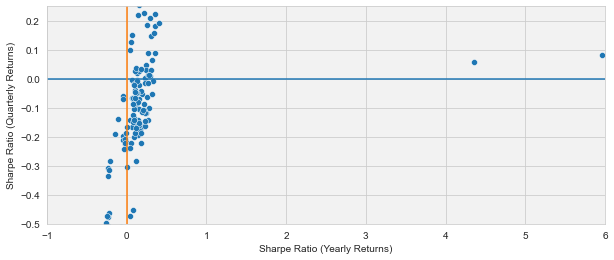

In [11]:
sns.set_style("whitegrid", {"axes.facecolor": "0.95"})
plt.figure(figsize = (10,4))
sns.scatterplot(x=sharpe_ratio_yearwise_ret, y=sharpe_ratio_quarterwise_ret)
plt.plot((-1,6), (0, 0))
plt.plot((0,0), (-0.55, 0.3))
plt.xlim(-1, 6)
plt.ylim(-0.5, 0.25)
plt.xlabel('Sharpe Ratio (Yearly Returns)')
plt.ylabel('Sharpe Ratio (Quarterly Returns)')
plt.show()

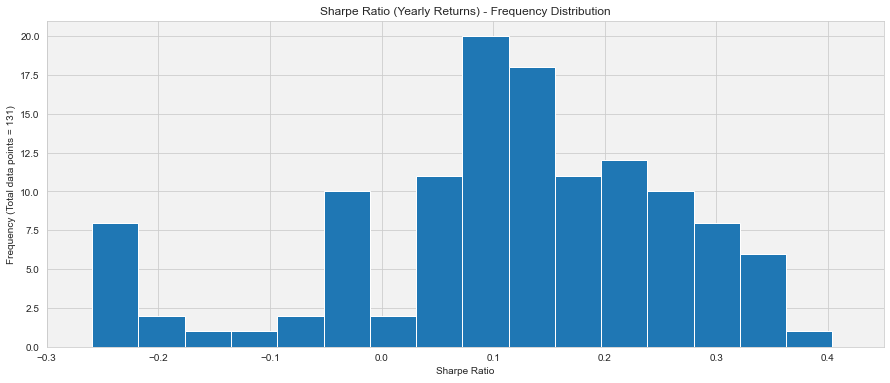

In [12]:
# Sharpe ratio frequency distribution
plt.figure(figsize=(15,6))
plt.hist(sharpe_ratio_yearwise_ret, bins = 150)
plt.xlim(-0.3, 0.45)
plt.xlabel('Sharpe Ratio')
plt.ylabel('Frequency (Total data points = 131)')
plt.title('Sharpe Ratio (Yearly Returns) - Frequency Distribution')
plt.show()

In [13]:
# Top funds by Sharpe ratio
sharpe_ratio_yearwise_ret[sharpe_ratio_yearwise_ret>0.3]

Fund Name
SBI Long Term Advantage Fund Series V - Direct Plan    5.95975
SBI Long Term Advantage Fund Series V - Regular Plan   4.35523
Quant Tax Plan - Direct Plan                           0.40407
Axis Long Term Equity Fund                             0.35905
Axis Long Term Equity Fund - Direct Plan               0.35428
Invesco India Tax Plan - Direct Plan                   0.35248
SBI Tax Advantage Fund - Series II                     0.34909
Canara Robeco Equity Tax Saver Fund - Direct Plan      0.32809
DSP Tax Saver Fund - Direct Plan                       0.32799
JM Tax Gain Fund - Direct Plan                         0.31465
Tata India Tax Savings Fund - Direct Plan              0.31210
Kotak Tax Saver - Direct Plan                          0.31133
Mirae Asset Tax Saver Fund - Direct Plan               0.30942
dtype: float64

## Drawdowns - Yearly and Quarterly Returns Data

In [14]:
yearwise_max_drawdown = (yearwise_ret.T/100).aggregate(rtk.compute_max_drawdown).sort_values()
yearwise_max_drawdown

Fund Name
Quant Tax Plan                                                              -0.38420
Sundaram Long Term Micro Cap Tax Advantage Fund Series III - Regular Plan   -0.37746
Sundaram Long Term Micro Cap Tax Advantage Fund Series III - Direct Plan    -0.37285
JM Tax Gain Fund                                                            -0.30960
Principal Tax Savings Fund                                                  -0.30380
                                                                              ...   
BOI AXA Midcap Tax Fund Series 2 - Direct Plan                               0.00000
SBI Long Term Advantage Fund Series V - Regular Plan                         0.00000
BOI AXA Midcap Tax Fund Series 2 - Regular Plan                              0.00000
Taurus Tax Shield Fund - Direct Plan                                         0.00000
ICICI Prudential Long Term Equity Fund (Tax Saving) - Direct Plan            0.00000
Length: 131, dtype: float64

In [15]:
quarterwise_max_drawdown = (quarterwise_ret.T/100).aggregate(rtk.compute_max_drawdown).sort_values()
quarterwise_max_drawdown

Fund Name
Sundaram Long Term Micro Cap Tax Advantage Fund Series VI - Regular Plan    -0.52170
Sundaram Long Term Micro Cap Tax Advantage Fund Series VI - Direct Plan     -0.51079
Sundaram Long Term Micro Cap Tax Advantage Fund Series III - Regular Plan   -0.50635
Sundaram Long Term Micro Cap Tax Advantage Fund Series IV - Regular Plan    -0.50606
Sundaram Long Term Micro Cap Tax Advantage Fund Series III - Direct Plan    -0.50311
                                                                              ...   
BOI AXA Tax Advantage Fund - Regular Plan                                   -0.18990
BOI AXA Tax Advantage Fund - Eco Plan                                       -0.18850
BOI AXA Tax Advantage Fund - Direct Plan                                    -0.18770
SBI Tax Advantage Fund - Series III - Regular Plan                          -0.18350
SBI Tax Advantage Fund - Series III - Direct Plan                           -0.18250
Length: 131, dtype: float64

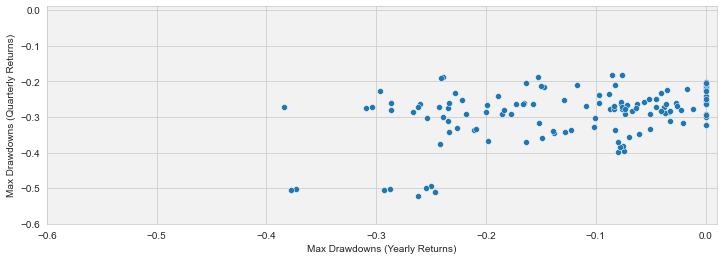

In [16]:
plt.figure(figsize = (12,4))
sns.scatterplot(x=yearwise_max_drawdown, y=quarterwise_max_drawdown)
plt.xlabel('Max Drawdowns (Yearly Returns)')
plt.ylabel('Max Drawdowns (Quarterly Returns)')
plt.xlim(-0.6, 0.01)
plt.ylim(-0.6, 0.01)
plt.show()

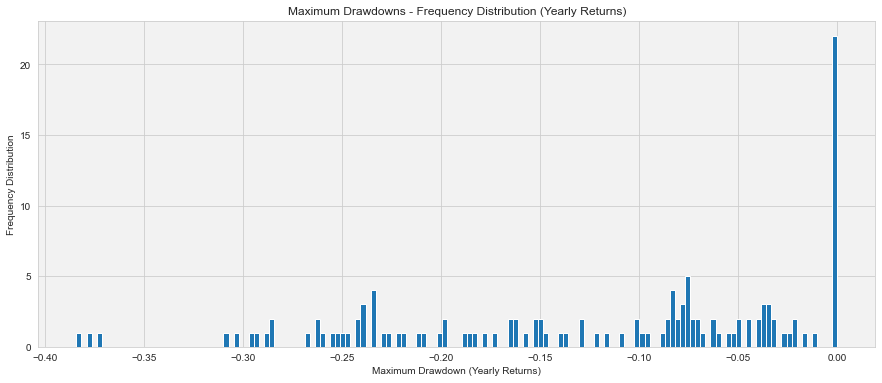

In [17]:
# Yearwise Max Drawdown frequency distribution
plt.figure(figsize=(15,6))
plt.hist(yearwise_max_drawdown, bins = 150)
plt.xlabel('Maximum Drawdown (Yearly Returns)')
plt.ylabel('Frequency Distribution')
plt.title('Maximum Drawdowns - Frequency Distribution (Yearly Returns)')
# plt.xlim(0, 0.5)
plt.show()

In [18]:
# Funds that suffered the worst drawdown
yearwise_max_drawdown[yearwise_max_drawdown<-0.25]

Fund Name
Quant Tax Plan                                                              -0.38420
Sundaram Long Term Micro Cap Tax Advantage Fund Series III - Regular Plan   -0.37746
Sundaram Long Term Micro Cap Tax Advantage Fund Series III - Direct Plan    -0.37285
JM Tax Gain Fund                                                            -0.30960
Principal Tax Savings Fund                                                  -0.30380
Aditya Birla Sun Life Tax Relief 96                                         -0.29620
Sundaram Long Term Micro Cap Tax Advantage Fund Series IV - Regular Plan    -0.29320
Sundaram Long Term Micro Cap Tax Advantage Fund Series IV - Direct Plan     -0.28770
Principal Personal Tax Saver Fund                                           -0.28670
Baroda ELSS 96 Fund                                                         -0.28650
DSP Tax Saver Fund                                                          -0.26680
Sundaram Long Term Micro Cap Tax Advantage Fund Series 

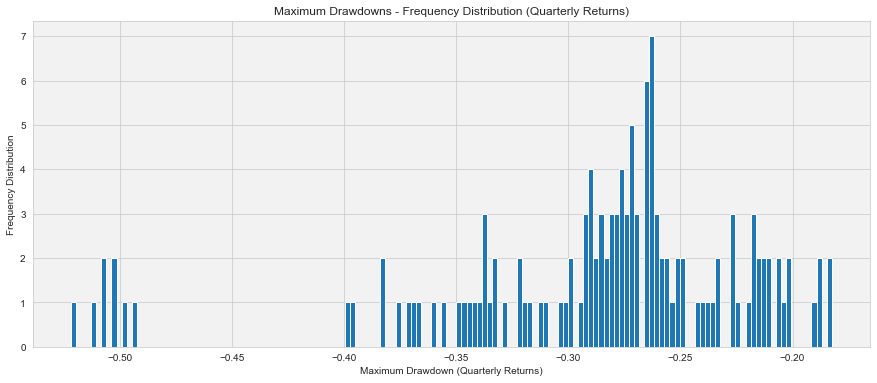

In [19]:
# Quarterwise Max Drawdown frequency distribution
plt.figure(figsize=(15,6))
plt.hist(quarterwise_max_drawdown, bins = 150)
plt.xlabel('Maximum Drawdown (Quarterly Returns)')
plt.ylabel('Frequency Distribution')
plt.title('Maximum Drawdowns - Frequency Distribution (Quarterly Returns)')
# plt.xlim(0, 0.5)
plt.show()

In [20]:
# Funds that suffered the least drawdown
quarterwise_max_drawdown[quarterwise_max_drawdown>-0.2]

Fund Name
BOI AXA Tax Advantage Fund - Regular Plan            -0.18990
BOI AXA Tax Advantage Fund - Eco Plan                -0.18850
BOI AXA Tax Advantage Fund - Direct Plan             -0.18770
SBI Tax Advantage Fund - Series III - Regular Plan   -0.18350
SBI Tax Advantage Fund - Series III - Direct Plan    -0.18250
dtype: float64

# Semideviation - Downside volatility

Semideviation is a measure of volatility of all returns that are negative. Higher semideviation figures represent higher downside risks.

In [21]:
yearwise_semidev = (yearwise_ret.T/100).aggregate(rtk.semideviation).sort_values(ascending = False)
quarterwise_semidev = (quarterwise_ret.T/100).aggregate(rtk.semideviation).sort_values(ascending = False)

In [22]:
yearwise_semidev

Fund Name
Quant Tax Plan                                          0.15334
JM Tax Gain Fund                                        0.13469
Aditya Birla Sun Life Tax Relief 96                     0.12565
LIC MF Tax Plan                                         0.11411
Baroda ELSS 96 Fund                                     0.10810
                                                          ...  
SBI Long Term Advantage Fund Series VI - Regular Plan       nan
SBI Long Term Advantage Fund Series V - Regular Plan        nan
Shriram Long Term Equity Fund - Direct Plan                 nan
Shriram Long Term Equity Fund - Regular Plan                nan
Taurus Tax Shield Fund - Direct Plan                        nan
Length: 131, dtype: float64

In [23]:
quarterwise_semidev

Fund Name
ICICI Prudential Long Term Wealth Enhancement Fund - Direct Plan   0.14017
ICICI Prudential Long Term Wealth Enhancement Fund                 0.13960
Franklin India Taxshield Fund - Direct Plan                        0.12471
HDFC Long Term Advantage Fund - Direct Plan                        0.12458
Franklin India Taxshield Fund                                      0.12437
                                                                     ...  
Shriram Long Term Equity Fund - Direct Plan                        0.00000
Shriram Long Term Equity Fund - Regular Plan                       0.00000
ITI Long Term Equity Fund - Regular Plan                           0.00000
ITI Long Term Equity Fund - Direct Plan                            0.00000
Parag Parikh Tax Saver Fund - Regular Plan                         0.00000
Length: 131, dtype: float64

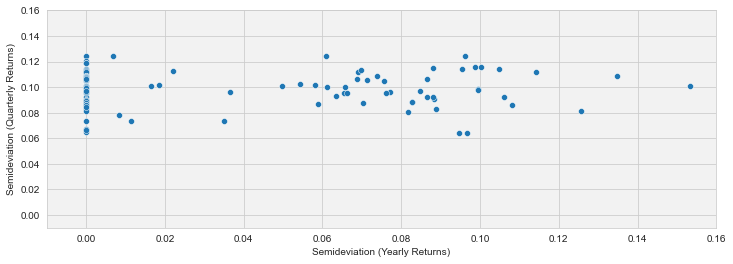

In [24]:
plt.figure(figsize = (12,4))
sns.scatterplot(x=yearwise_semidev, y=quarterwise_semidev)
plt.xlabel('Semideviation (Yearly Returns)')
plt.ylabel('Semideviation (Quarterly Returns)')
plt.xlim(-0.01, 0.16)
plt.ylim(-0.01, 0.16)
plt.show()

In [25]:
semidev_df = pd.DataFrame({'semidev_yearly':yearwise_semidev, 'semidev_quarterly':quarterwise_semidev}, index = yearwise_semidev.index)
semidev_df[(semidev_df['semidev_yearly']>0.1) & (semidev_df['semidev_quarterly']>0.06)]

,semidev_yearly,semidev_quarterly
Fund Name,,
Quant Tax Plan,0.15334,0.10103
JM Tax Gain Fund,0.13469,0.10902
Aditya Birla Sun Life Tax Relief 96,0.12565,0.08117
LIC MF Tax Plan,0.11411,0.11152
Baroda ELSS 96 Fund,0.10810,0.08629
Principal Tax Savings Fund,0.10615,0.09198
Nippon India Tax Saver (ELSS) Fund,0.10477,0.11445
Quantum Tax Saving Fund - Direct Plan,0.10020,0.11582


## Investigate Quant Tax Plan

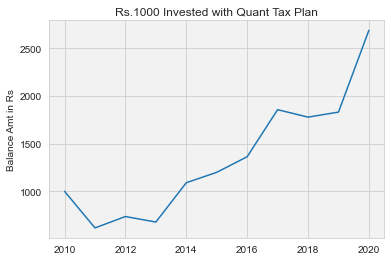

In [26]:
# Compute how Rs.1000 invested in Quant Tax Plan grew over the last decade
wealth = rtk.compute_drawdown((yearwise_ret.T/100)['Quant Tax Plan']).Wealth
wealth[2010]=1000
wealth.sort_index(inplace = True)
wealth.plot(title='Rs.1000 Invested with Quant Tax Plan', ylabel='Balance Amt in Rs')
plt.show()

In [27]:
(yearwise_ret.T/100)['Quant Tax Plan']

2011   -0.38420
2012    0.19420
2013   -0.07870
2014    0.60920
2015    0.10000
2016    0.13670
2017    0.36230
2018   -0.04220
2019    0.02970
2020    0.46920
Name: Quant Tax Plan, dtype: float64

## VaR - Value at Risk

VaR is the minimum amount of loss expected to incur at a certain % of time. We calculate modified using the Cornish-Fisher modification to account for non-normality of returns at 5% level. This indicates the minimum level of loss one should expect in one year period when invested in these funds over a 20 year period. Alternatively, when using quarterly returns, it is the minimum loss one should expect to incur over a quarter when invested for 5 quarters.

In [28]:
# VaR based on yearly returns
yearwisevar_modified_gaussian = (yearwise_ret.T/100).aggregate(rtk.var_gaussian, axis=0, level = 5, modified = True).sort_values()
yearwisevar_modified_gaussian.sort_values(ascending = False).head(10)

/Users/vignesh/Desktop/EveryFin/Weekly Newsletters/Sunday Weekly/Issue 25/risk_toolkit.py:71: RuntimeWarning: invalid value encountered in double_scalars
  skew = exp/sigma_r**3
/Users/vignesh/Desktop/EveryFin/Weekly Newsletters/Sunday Weekly/Issue 25/risk_toolkit.py:85: RuntimeWarning: invalid value encountered in double_scalars
  kurt = exp/sigma_r**4


Fund Name
Sundaram Long Term Micro Cap Tax Advantage Fund Series III - Regular Plan   0.40659
Sundaram Long Term Micro Cap Tax Advantage Fund Series III - Direct Plan    0.40541
Sundaram Long Term Micro Cap Tax Advantage Fund Series IV - Regular Plan    0.38770
Sundaram Long Term Micro Cap Tax Advantage Fund Series IV - Direct Plan     0.38159
Sundaram Long Term Micro Cap Tax Advantage Fund Series VI - Regular Plan    0.35137
Sundaram Long Term Micro Cap Tax Advantage Fund Series V - Regular Plan     0.34902
Sundaram Long Term Micro Cap Tax Advantage Fund Series V - Direct Plan      0.34402
Sundaram Long Term Micro Cap Tax Advantage Fund Series VI - Direct Plan     0.33488
Quant Tax Plan                                                              0.31780
Nippon India Tax Saver (ELSS) Fund                                          0.30727
dtype: float64

In [29]:
# VaR based on quarterly returns
quarterwisevar_modified_gaussian = (quarterwise_ret.T/100).aggregate(rtk.var_gaussian, axis=0, level = 5, modified = True).sort_values()
quarterwisevar_modified_gaussian.sort_values(ascending = False).head(10)

Fund Name
ITI Long Term Equity Fund - Regular Plan                                   0.34307
ITI Long Term Equity Fund - Direct Plan                                    0.33966
Sundaram Long Term Micro Cap Tax Advantage Fund Series VI - Regular Plan   0.27697
Sundaram Long Term Micro Cap Tax Advantage Fund Series VI - Direct Plan    0.27517
Nippon India Tax Saver (ELSS) Fund                                         0.26794
Sundaram Long Term Micro Cap Tax Advantage Fund Series IV - Regular Plan   0.26731
Sundaram Long Term Micro Cap Tax Advantage Fund Series IV - Direct Plan    0.26645
Nippon India Tax Saver (ELSS) Fund - Direct Plan                           0.26643
Sundaram Long Term Micro Cap Tax Advantage Fund Series V - Regular Plan    0.26518
Sundaram Long Term Tax Advantage Fund Series III - Regular Plan            0.26516
dtype: float64

## Fund Performance - Alpha

Alpha is the excess return the fund earns in comparison to its benchmark. A higher alpha is typically attributed to better stock selection or better timing.

In [30]:
fund_performance = sheet_to_df_map['fund-performance']
fund_performance['1year_alpha'] = (fund_performance['Return 1 Year (%) Direct'] - fund_performance['Return 1 Year (%) Benchmark'])/100
fund_performance['3year_alpha']= (fund_performance['Return 3 Year (%) Direct'] - fund_performance['Return 3 Year (%) Benchmark'])/100
fund_performance['5year_alpha']= (fund_performance['Return 5 Year (%) Direct'] - fund_performance['Return 5 Year (%) Benchmark'])/100
fund_performance.head(2)

,Benchmark,Return 1 Year (%) Regular,Return 1 Year (%) Direct,Return 1 Year (%) Benchmark,Return 3 Year (%) Regular,Return 3 Year (%) Direct,Return 3 Year (%) Benchmark,Return 5 Year (%) Regular,Return 5 Year (%) Direct,Return 5 Year (%) Benchmark,Return 10 Year (%) Regular,Return 10 Year (%) Direct,Return 10 Year (%) Benchmark,Return Since Launch Regular,Return Since Launch Direct,Return Since Launch Benchmark,Daily AUM (Cr.),1year_alpha,3year_alpha,5year_alpha
Scheme Name,,,,,,,,,,,,,,,,,,,,
Aditya Birla Sun Life Tax Relief 96 Fund,S&P BSE 200 Total Return Index,45.20996,46.45753,67.81378,8.16964,9.22607,13.48350,13.99272,15.12260,16.23619,13.79123,nan,12.43984,23.23634,16.28864,13.19970,13530.61000,-0.21356,-0.04257,-0.01114
Axis Long Term Equity Fund,S&P BSE 200 Total Return Index,48.51413,49.76788,67.81378,15.37616,16.41237,13.48350,16.78379,17.93525,16.23619,18.01275,nan,12.43984,17.58648,20.02753,11.44824,28262.90921,-0.18046,0.02929,0.01699


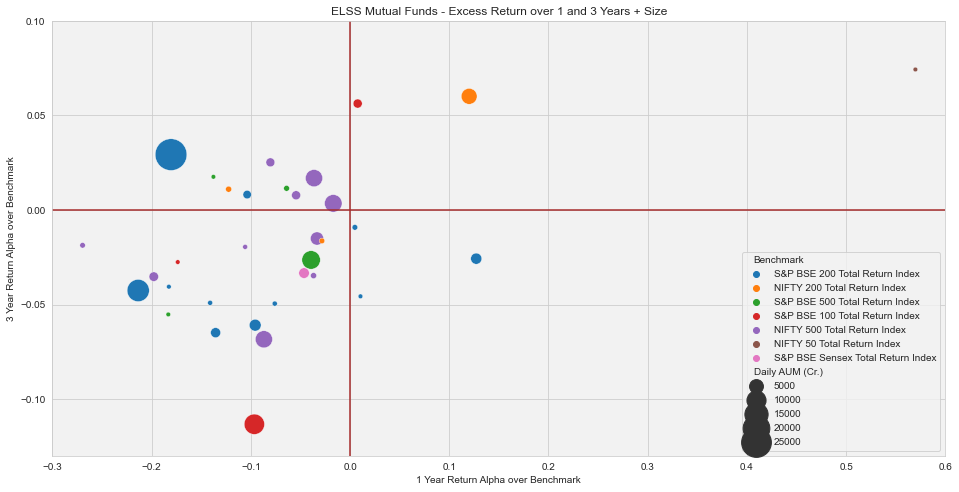

In [31]:
# 1 year vs 3 year performance against benchmark
x = fund_performance['1year_alpha']
y = fund_performance['3year_alpha']
size = fund_performance['Daily AUM (Cr.)']
hue = fund_performance['Benchmark']
sns.set_style("whitegrid", {"axes.facecolor": "0.95"})
plt.rcParams['figure.figsize'] = [16, 8]
plt.xlabel('1 Year Return Alpha over Benchmark')
plt.ylabel('3 Year Return Alpha over Benchmark')
plt.title('ELSS Mutual Funds - Excess Return over 1 and 3 Years + Size')
sns.scatterplot(x=x, y=y, size=size, legend = True, sizes=(20, 1000),hue = hue)
plt.xlim(-0.3, 0.6)
plt.ylim(-0.13, 0.1)
plt.plot((0,0), (-0.13, 0.1), color='brown')
plt.plot((-0.3,0.6), (0, 0), color='brown')
# for i in range(fund_performance.shape[0]):
#     plt.text(x=fund_performance['1year_alpha'][i]+0.01,
#              y=fund_performance['3year_alpha'][i]+0.005,
#              s=fund_performance.index[i],
#              fontdict=dict(color='red',size=10),
#              bbox=dict(facecolor='white',alpha=0.95))
plt.show()

In [32]:
pd.DataFrame({'1 year alpha':x, '3 year alpha':y, 'AUM':size, 'Benchmark':hue}, index=fund_performance.index)

,1 year alpha,3 year alpha,AUM,Benchmark
Scheme Name,,,,
Aditya Birla Sun Life Tax Relief 96 Fund,-0.21356,-0.04257,13530.61000,S&P BSE 200 Total Return Index
Axis Long Term Equity Fund,-0.18046,0.02929,28262.90921,S&P BSE 200 Total Return Index
Baroda ELSS 96 Fund,-0.07591,-0.04951,198.52460,S&P BSE 200 Total Return Index
BNP Paribas Long Term Equity Fund,-0.12242,0.01101,501.17095,NIFTY 200 Total Return Index
BOI AXA Tax Advantage Fund,-0.06399,0.01146,409.56106,S&P BSE 500 Total Return Index
Canara Robeco Equity Tax Saver Fund,0.00767,0.05630,1803.73337,S&P BSE 100 Total Return Index
DSP Tax Saver Fund,-0.03632,0.01684,7901.22052,NIFTY 500 Total Return Index
Edelweiss Long Term Equity Fund (Tax Savings),-0.10577,-0.01952,163.02000,NIFTY 500 Total Return Index
Essel Long Term Advantage Fund,-0.17369,-0.02754,62.43747,S&P BSE 100 Total Return Index


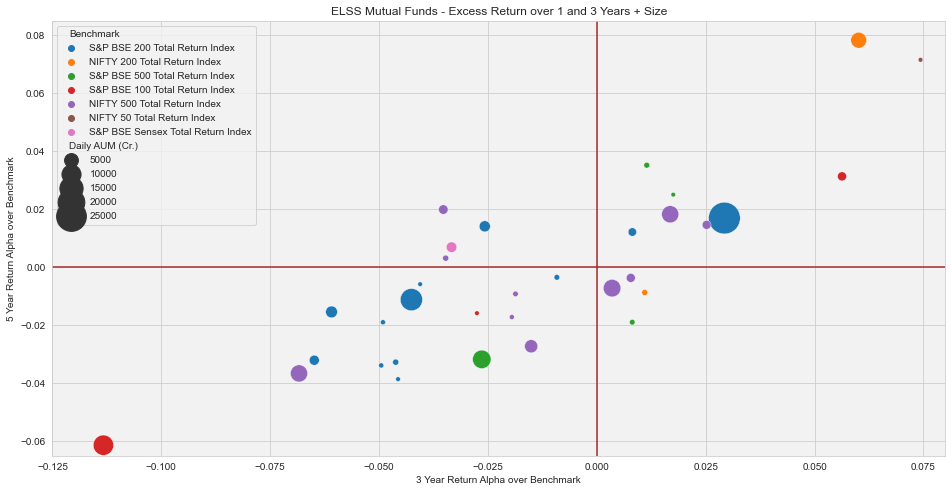

In [33]:
# 3 year vs 5 year performance against benchmark
x = fund_performance['3year_alpha']
y = fund_performance['5year_alpha']
size = fund_performance['Daily AUM (Cr.)']
hue = fund_performance['Benchmark']
sns.set_style("whitegrid", {"axes.facecolor": "0.95"})
plt.rcParams['figure.figsize'] = [16, 8]
plt.xlabel('3 Year Return Alpha over Benchmark')
plt.ylabel('5 Year Return Alpha over Benchmark')
plt.title('ELSS Mutual Funds - Excess Return over 1 and 3 Years + Size')
sns.scatterplot(x=x, y=y, size=size, legend = True, sizes=(20, 1000),hue = hue)
plt.xlim(-0.125, 0.08)
plt.ylim(-0.065, 0.085)
plt.plot((0,0), (-0.065, 0.85), color='brown')
plt.plot((-0.125,0.08), (0, 0), color='brown')
# for i in range(fund_performance.shape[0]):
#     plt.text(x=fund_performance['1year_alpha'][i]+0.01,
#              y=fund_performance['3year_alpha'][i]+0.005,
#              s=fund_performance.index[i],
#              fontdict=dict(color='red',size=10),
#              bbox=dict(facecolor='white',alpha=0.95))
plt.show()

In [ ]:
pd.DataFrame({'3 year alpha':x, '5 year alpha':y, 'AUM':size, 'Benchmark':hue}, index=fund_performance.index)

## Funds we are most interested in

1. Quant tax plan
2. Mirae asset tax saver fund
3. SBI Long term advantage fund series V
4. Canara Robeco Equity tax saver fund
5. BOI AXA Midcap Tax Fund Series 2

Let's investigate them.

In [34]:
def scrape_it(url):
    req = Request(url, headers = {'User-Agent':'Mozilla/5.0'})
    html = urlopen(req)
    dfs = pd.read_html(html)
    soup = BeautifulSoup(html)
    return dfs, soup
def get_holdings_valueresearchonline(url):
    dfs, soup = scrape_it(url)
    holdings = dfs[6]
    holdings.index = holdings.Company
    holdings.drop(['Unnamed: 0', 'Company', '3Y High', '3Y Low'], axis=1, inplace = True)
    return holdings

In [35]:
holdings_lst = []
funds = ['quant_tax_plan', 'mirae_asset_tax_saver', 'sbi_longterm_adv_series_v', 'canara_robeco_equity_tax_saver', 'boi_axa_midcap_tax']
urls = ['https://www.valueresearchonline.com/funds/17381/quant-tax-plan-direct-plan',
        'https://www.valueresearchonline.com/funds/31318/mirae-asset-tax-saver-fund-direct-plan',
        'https://www.valueresearchonline.com/funds/34958/sbi-long-term-advantage-fund-series-v-regular-plan',
        'https://www.valueresearchonline.com/funds/16594/canara-robeco-equity-tax-saver-fund-direct-plan',
        'https://www.valueresearchonline.com/funds/36922/boi-axa-midcap-tax-fund-series-2-direct-plan']
for i in range(len(funds)):
    holdings = get_holdings_valueresearchonline(urls[i])
    holdings.columns = ['sector', 'pe_ratio', funds[i]]
    holdings_lst.append(holdings)

In [36]:
holdings = pd.concat([x.iloc[:, :2] for x in holdings_lst])
holdings = holdings[~holdings.index.duplicated(keep='first')]
for i in range(len(holdings_lst)):
    holdings = pd.concat([holdings, holdings_lst[i].iloc[:, 2:]], axis = 1)
holdings.fillna(value=0.0, inplace = True)
holdings

,sector,pe_ratio,quant_tax_plan,mirae_asset_tax_saver,sbi_longterm_adv_series_v,canara_robeco_equity_tax_saver,boi_axa_midcap_tax
Bharti Airtel,Communication,--,6.00000,2.90000,0.00000,0.00000,0.00000
Fortis Healthcare (India),Healthcare,--,5.49000,0.00000,0.00000,0.00000,0.00000
Infosys,Technology,30.82,5.32000,7.05000,3.28000,7.81000,1.91000
Tata Consultancy Services,Technology,36.80,5.29000,4.31000,3.24000,2.06000,0.00000
NMDC,Metals,10.40,5.26000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...
Endurance Technologies,Automobile,45.41000,0.00000,0.00000,0.00000,0.00000,1.97000
Dr. Lal Pathlabs,Healthcare,87.19000,0.00000,0.00000,0.00000,0.00000,1.96000
Route Mobile,Technology,155.28000,0.00000,0.00000,0.00000,0.00000,1.95000
AIA Engineering,Metals,30.66000,0.00000,0.00000,0.00000,0.00000,1.89000


In [37]:
holdings['Total'] = holdings.iloc[:, 2:7].sum(axis=1)
holdings.sort_values(by='Total', ascending=False).head(10)

,sector,pe_ratio,quant_tax_plan,mirae_asset_tax_saver,sbi_longterm_adv_series_v,canara_robeco_equity_tax_saver,boi_axa_midcap_tax,Total
HDFC Bank,Financial,26.90,0.00000,9.34000,10.40000,6.16000,3.98000,29.88000
Infosys,Technology,30.82,5.32000,7.05000,3.28000,7.81000,1.91000,25.37000
ICICI Bank,Financial,27.50,0.00000,7.01000,7.29000,8.69000,0.00000,22.99000
State Bank of India,Financial,14.28,0.00000,3.10000,5.89000,6.73000,0.00000,15.72000
Tata Consultancy Services,Technology,36.80,5.29000,4.31000,3.24000,2.06000,0.00000,14.90000
Axis Bank,Financial,74.37,0.00000,4.66000,2.00000,3.90000,0.00000,10.56000
Bharti Airtel,Communication,--,6.00000,2.90000,0.00000,0.00000,0.00000,8.90000
Dixon Technologies,Engineering,174.69000,0.00000,0.00000,6.87000,1.49000,0.00000,8.36000
Divi's Laboratories,Healthcare,47.83000,0.00000,0.00000,5.65000,2.06000,0.00000,7.71000
BPCL,Energy,23.39,2.96000,1.82000,2.18000,0.00000,0.00000,6.96000


In [38]:
holdings['average'] = holdings.iloc[:, 2:7].mean(axis=1)
holdings.sort_values(by='average', ascending=False).head(10)

,sector,pe_ratio,quant_tax_plan,mirae_asset_tax_saver,sbi_longterm_adv_series_v,canara_robeco_equity_tax_saver,boi_axa_midcap_tax,Total,average
HDFC Bank,Financial,26.90,0.00000,9.34000,10.40000,6.16000,3.98000,29.88000,5.97600
Infosys,Technology,30.82,5.32000,7.05000,3.28000,7.81000,1.91000,25.37000,5.07400
ICICI Bank,Financial,27.50,0.00000,7.01000,7.29000,8.69000,0.00000,22.99000,4.59800
State Bank of India,Financial,14.28,0.00000,3.10000,5.89000,6.73000,0.00000,15.72000,3.14400
Tata Consultancy Services,Technology,36.80,5.29000,4.31000,3.24000,2.06000,0.00000,14.90000,2.98000
Axis Bank,Financial,74.37,0.00000,4.66000,2.00000,3.90000,0.00000,10.56000,2.11200
Bharti Airtel,Communication,--,6.00000,2.90000,0.00000,0.00000,0.00000,8.90000,1.78000
Dixon Technologies,Engineering,174.69000,0.00000,0.00000,6.87000,1.49000,0.00000,8.36000,1.67200
Divi's Laboratories,Healthcare,47.83000,0.00000,0.00000,5.65000,2.06000,0.00000,7.71000,1.54200
BPCL,Energy,23.39,2.96000,1.82000,2.18000,0.00000,0.00000,6.96000,1.39200


In [39]:
holdings['count'] = holdings.iloc[:, 2:7].T[holdings.iloc[:, 2:7].T>0].count()
holdings.sort_values(by='count',ascending=False).head(10)

,sector,pe_ratio,quant_tax_plan,mirae_asset_tax_saver,sbi_longterm_adv_series_v,canara_robeco_equity_tax_saver,boi_axa_midcap_tax,Total,average,count
Infosys,Technology,30.82,5.32000,7.05000,3.28000,7.81000,1.91000,25.37000,5.07400,5
Tata Consultancy Services,Technology,36.80,5.29000,4.31000,3.24000,2.06000,0.00000,14.90000,2.98000,4
HDFC Bank,Financial,26.90,0.00000,9.34000,10.40000,6.16000,3.98000,29.88000,5.97600,4
ICICI Bank,Financial,27.50,0.00000,7.01000,7.29000,8.69000,0.00000,22.99000,4.59800,3
BPCL,Energy,23.39,2.96000,1.82000,2.18000,0.00000,0.00000,6.96000,1.39200,3
Axis Bank,Financial,74.37,0.00000,4.66000,2.00000,3.90000,0.00000,10.56000,2.11200,3
State Bank of India,Financial,14.28,0.00000,3.10000,5.89000,6.73000,0.00000,15.72000,3.14400,3
Maruti Suzuki India,Automobile,48.05,0.00000,2.54000,0.00000,1.33000,0.00000,3.87000,0.77400,2
Cholamandalam Invest. & Fin.,Financial,34.38000,0.00000,0.00000,0.00000,1.82000,3.56000,5.38000,1.07600,2
HDFC,Financial,26.09,0.00000,2.32000,0.00000,2.43000,0.00000,4.75000,0.95000,2


In [40]:
holdings.iloc[:, 2:7].T

,Bharti Airtel,Fortis Healthcare (India),Infosys,Tata Consultancy Services,NMDC,Tech Mahindra,General Insurance Corporation of India,ITC,Stylam Industries,Oracle Fin Ser Software,...,AU Small Finance Bank,Navin Fluorine International,Laurus Labs,Tube Investments Of India,City Union Bank,Endurance Technologies,Dr. Lal Pathlabs,Route Mobile,AIA Engineering,JB Chemicals & Pharma
quant_tax_plan,6.00000,5.49000,5.32000,5.29000,5.26000,5.23000,4.94000,4.77000,4.71000,4.07000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
mirae_asset_tax_saver,2.90000,0.00000,7.05000,4.31000,0.00000,0.00000,0.00000,1.72000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
sbi_longterm_adv_series_v,0.00000,0.00000,3.28000,3.24000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
canara_robeco_equity_tax_saver,0.00000,0.00000,7.81000,2.06000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
boi_axa_midcap_tax,0.00000,0.00000,1.91000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,2.36000,2.35000,2.22000,2.18000,2.02000,1.97000,1.96000,1.95000,1.89000,1.81000


# PCA on overall mutual funds list based on historical returns

In [43]:
trimmed_dataset = dataset.copy()
trimmed_dataset = trimmed_dataset.drop(['launch', 'latest_nav', '52_week_high_nav', '52_week_low_nav',
                                      'Fund Manager (Tenure)', 'net_assets_crores'], axis=1)
trimmed_dataset = trimmed_dataset.fillna(value=trimmed_dataset.mean())
trimmed_dataset.head(2)

,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,...,Sep-18,Dec-18,Mar-19,Jun-19,Sep-19,Dec-19,Mar-20,Jun-20,Sep-20,Dec-20
Aditya Birla Sun Life Tax Plan,-22.86000,36.15000,8.55000,52.83000,8.22000,3.11000,42.50000,-5.07000,3.57000,14.31000,...,-1.40000,0.11000,2.85000,-2.70000,-2.41000,6.04000,-23.41000,18.49000,7.47000,17.21000
Aditya Birla Sun Life Tax Plan - Direct Plan,-23.48697,31.79647,6.58514,54.13000,9.25000,4.27000,44.13000,-4.09000,4.31000,14.98000,...,-1.14000,0.32000,3.09000,-2.57000,-2.22000,6.21000,-23.29000,18.67000,7.66000,17.32000


In [ ]:
trimmed_dataset.columns

In [44]:
# Similarity across all funds based on return profile
x = np.array(trimmed_dataset)
x_demeaned = (x - np.mean(x))/(np.std(x))
cov_mat = np.cov(x_demeaned, rowvar=False)
eigenvals, eigenvec = np.linalg.eigh(cov_mat)
idx_sorted_eigenvals = np.argsort(eigenvals)[::-1]
sorted_eigenvals = eigenvals[idx_sorted_eigenvals]
sorted_eigenvec = eigenvec[:, idx_sorted_eigenvals]
feat = sorted_eigenvec[:, :2]
pca = np.dot(feat.T, x_demeaned.T).T

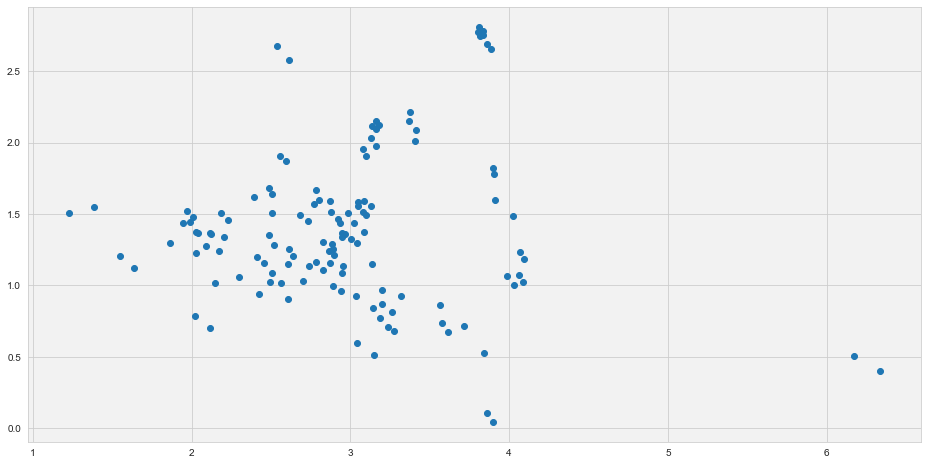

In [45]:
%matplotlib inline
plt.figure(figsize=(16,8))
plt.scatter(pca[:,0], pca[:,1])
# for i in range(pca.shape[0]):
#     plt.text(x=pca[i, 0]-0.3,
#              y=pca[i, 1]-0.6,
#              s=trimmed_dataset.index[i],
#              fontdict=dict(color='red',size=15),
#              bbox=dict(facecolor='white',alpha=0.95))

PCA does not tell us if there are clear clusters in terms of mutual funds based on historic returns. This could be because return data is not available for all years from 2010 for all mutual funds - some MFs starter much later than 2010 and hence do not have data for prior years. This makes PCA using historic returns a poor method in comparing similarities.

## PCA using portfolio components of all mutual funds

Let's use portfolio composition instead to understand if there are different clusters of ELSS funds based on investment styles. And also investigate how similar or different they are to NIFTY50 and SENSEX30 constituents.

In [46]:
import time
url = r'https://www.valueresearchonline.com/funds/selector/category/106/equity-elss/?end-type=1&plan-type=direct&tab=snapshot'
from selenium import webdriver
# Chromedriver.exe is in usr/local/bin (which is the PATH)
browser = webdriver.Chrome()
with webdriver.Chrome() as driver:
    driver.get(url)
    time.sleep(3)
    soup = BeautifulSoup(driver.page_source, 'lxml')
driver.quit()

In [47]:
tables = soup.find_all('table')
dfs = pd.read_html(str(tables))
dfs[1].index = dfs[1]['Fund Name']
dfs[1].index = [re.sub('[^\S]\|[^\S].*', '', str(x)) for x in dfs[1].index]
# There are 41 funds in total
dfs[1].drop(['Unnamed: 0', 'Fund Name', 'Rating', "Analysts\' View", '1 Yr Rank'], axis=1)

,Category,Launch,Expense Ratio (%),1 Yr Ret (%),Net Assets (Cr)
Aditya Birla SL Tax Plan Direct,EQ-ELSS,Jan-13,1.85000,58.96000,529
ABSL Tax Relief 96 Dir,EQ-ELSS,Jan-13,0.94000,59.63000,13427
Axis Long Term Equity Dir,EQ-ELSS,Jan-13,0.72000,62.66000,27216
Baroda ELSS 96 Dir,EQ-ELSS,Jan-13,1.81000,74.73000,193
BNP Paribas Long Term Equity Dir,EQ-ELSS,Jan-13,1.09000,62.55000,496
BOI AXA Tax Advantage Dir,EQ-ELSS,Jan-13,1.51000,77.41000,399
Canara Robeco Eqt Tax Saver Dir,EQ-ELSS,Jan-13,1.06000,81.90000,1724
DSP Tax Saver Dir,EQ-ELSS,Jan-13,0.80000,77.86000,7883
Edelweiss LT Eqt (Tax Svngs) Dir,EQ-ELSS,Jan-13,0.69000,72.03000,161
Essel Long Term Advantage Dir,EQ-ELSS,Dec-15,0.38000,63.43000,63


In [48]:
urls = []
funds = []
for link in soup.find_all('a', href=re.compile('^/funds/[0-9]')):
    urls.append(r'https://www.valueresearchonline.com' + link.get('href'))
    funds.append(link.get_text())

#     Include Nifty50 ETF and Sensex30 ETF into the mix to get composition of these funds too
funds.append('nifty50')
urls.append('https://www.valueresearchonline.com/funds/31376/hdfc-nifty-50-etf/')
funds.append('sensex30')
urls.append('https://www.valueresearchonline.com/funds/31377/hdfc-sensex-etf/')

In [ ]:
for a, b in zip(urls, funds):
    print(a, b)

In [49]:
holdings_lst = []
for i in range(len(funds)):
    holdings = get_holdings_valueresearchonline(urls[i])
    holdings.columns = ['sector', 'pe_ratio', funds[i]]
    holdings_lst.append(holdings)
    print('Done with ', funds[i])

Done with  Aditya Birla SL Tax Plan Direct
Done with  ABSL Tax Relief 96 Dir
Done with  Axis Long Term Equity Dir
Done with  Baroda ELSS 96 Dir
Done with  BNP Paribas Long Term Equity Dir
Done with  BOI AXA Tax Advantage Dir
Done with  Canara Robeco Eqt Tax Saver Dir
Done with  DSP Tax Saver Dir
Done with  Edelweiss LT Eqt (Tax Svngs) Dir
Done with  Essel Long Term Advantage Dir
Done with  Franklin Taxshield Dir
Done with  HDFC Long Term Advantage Direct
Done with  HDFC Taxsaver Dir
Done with  HSBC Tax Saver Eqt Dir
Done with  ICICI Pru LT Eqt (Tax Saving) Dir
Done with  IDBI Eqt Advantage Dir
Done with  IDFC Tax Advantage (ELSS) Dir
Done with  Indiabulls Tax Savings Dir
Done with  Invesco India Tax Dir
Done with  ITI Long Term Equity Dir
Done with  JM Tax Gain Dir
Done with  Kotak Tax Saver Dir
Done with  LIC MF Tax Dir
Done with  L&T Tax Advantage Dir
Done with  Mahindra Manulife ELSS Kar Bachat Yojana Dir
Done with  Mirae Asset Tax Saver Dir
Done with  Motilal Oswal Long Term Eqt Di

In [50]:
holdings = pd.DataFrame()
holdings = pd.concat([x.iloc[:, :2] for x in holdings_lst])
holdings = holdings[~holdings.index.duplicated(keep='first')]
for i in range(len(holdings_lst)):
    holdings = pd.concat([holdings, holdings_lst[i].iloc[:, 2:]], axis = 1)
holdings.fillna(value=0.0, inplace = True)
holdings.head(4)

,sector,pe_ratio,Aditya Birla SL Tax Plan Direct,ABSL Tax Relief 96 Dir,Axis Long Term Equity Dir,Baroda ELSS 96 Dir,BNP Paribas Long Term Equity Dir,BOI AXA Tax Advantage Dir,Canara Robeco Eqt Tax Saver Dir,DSP Tax Saver Dir,...,Quantum Tax Saving Dir,SBI Long Term Equity Fund Dir,Shriram Long Term Equity Dir,Sundaram Diversified Equity Dir,Tata India Tax Savings Dir,Taurus Tax Shield Dir,Union Long Term Equity Dir,UTI Long Term Equity Dir,nifty50,sensex30
Honeywell Automation,Engineering,80.80,9.75000,10.11000,0.00000,0.00000,0.00000,1.79000,1.31000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.06000,0.00000,0.00000,0.00000
HDFC,Financial,26.09,8.80000,9.14000,5.64000,1.70000,1.54000,2.73000,2.43000,0.00000,...,8.46000,2.65000,4.40000,5.07000,4.53000,3.29000,4.80000,5.18000,7.28000,8.45000
Pfizer,Healthcare,40.30,6.31000,6.36000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Kotak Mahindra Bank,Financial,39.00,5.93000,5.91000,6.45000,0.00000,2.51000,2.66000,0.00000,0.00000,...,0.00000,0.00000,3.62000,0.00000,2.43000,3.39000,1.31000,0.00000,4.16000,4.42000


In [51]:
holdings['Total'] = holdings.iloc[:, 2:45].sum(axis=1)
holdings['Total'].sort_values(ascending=False).head(10)

HDFC Bank                   301.29000
ICICI Bank                  272.24000
Infosys                     252.09000
Reliance Industries         154.34000
HDFC                        135.83000
Bharti Airtel               114.17000
Axis Bank                   110.13000
State Bank of India          99.32000
Tata Consultancy Services    92.58000
Larsen & Toubro              90.57000
Name: Total, dtype: float64

In [52]:
holdings['average'] = holdings.iloc[:, 2:45].mean(axis=1)
holdings[['average', 'Total']].sort_values(by='average', ascending=False).head(10)

,average,Total
HDFC Bank,7.00674,301.29000
ICICI Bank,6.33116,272.24000
Infosys,5.86256,252.09000
Reliance Industries,3.58930,154.34000
HDFC,3.15884,135.83000
Bharti Airtel,2.65512,114.17000
Axis Bank,2.56116,110.13000
State Bank of India,2.30977,99.32000
Tata Consultancy Services,2.15302,92.58000
Larsen & Toubro,2.10628,90.57000


In [53]:
holdings['count'] = holdings.iloc[:, 2:45].T[holdings.iloc[:, 2:45].T>0].count()
holdings[['average', 'Total', 'count']].sort_values(by='count', ascending=False).head(10)

,average,Total,count
HDFC Bank,7.00674,301.29000,42
Infosys,5.86256,252.09000,40
ICICI Bank,6.33116,272.24000,40
Bharti Airtel,2.65512,114.17000,35
HDFC,3.15884,135.83000,33
Axis Bank,2.56116,110.13000,31
Reliance Industries,3.58930,154.34000,30
State Bank of India,2.30977,99.32000,29
Larsen & Toubro,2.10628,90.57000,27
Kotak Mahindra Bank,1.97953,85.12000,26


In [54]:
# PCA
# Similarity using PCA on portfolio holdings
# These rows may need altering
x = np.array(holdings.iloc[:, 2:45].T)
x_demeaned = (x - np.mean(x))/(np.std(x))
cov_mat = np.cov(x_demeaned, rowvar=False)
eigenvals, eigenvec = np.linalg.eigh(cov_mat)
idx_sorted_eigenvals = np.argsort(eigenvals)[::-1]
sorted_eigenvals = eigenvals[idx_sorted_eigenvals]
sorted_eigenvec = eigenvec[:, idx_sorted_eigenvals]
feat = sorted_eigenvec[:, :2]
pca = np.dot(feat.T, x_demeaned.T).T
pca.shape

(43, 2)

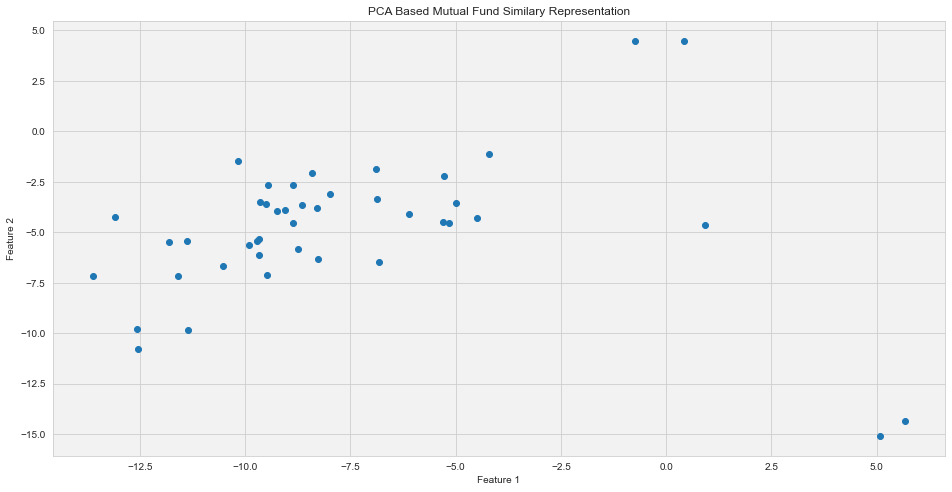

In [55]:
%matplotlib inline
plt.figure(figsize=(16,8))
plt.scatter(pca[:,0], pca[:,1])
# for i in range(pca.shape[0]):
#     plt.text(x=pca[i, 0]+0.3,
#              y=pca[i, 1]-0.6,
#              s=holdings.iloc[:, 2:-3].T.index[i],
#              fontdict=dict(color='red',size=15),
#              bbox=dict(facecolor='white',alpha=0.95))
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('PCA Based Mutual Fund Similary Representation')
plt.show()

In [ ]:
overall_pca = pd.DataFrame(pca, index = holdings.iloc[:, 2:-3].T.index, columns = ['Feature 1', 'Feature 2'])
# pd.concat([overall_pca, ], axis=1)
overall_pca['AUM'] = dfs[1]['Net Assets (Cr)']
overall_pca

## Finally, the fees - Expense Ratio

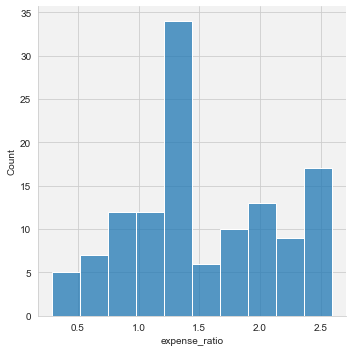

In [56]:
# Fees are on almost all ranges. But about 1.25% expense ratio is the average
sns.displot(x=snapshot.expense_ratio, bins=10)
plt.show()

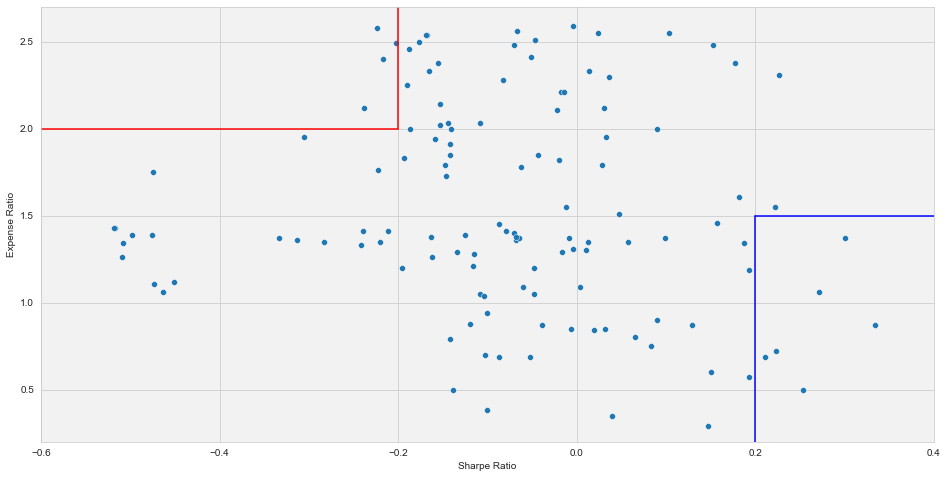

In [57]:
sharpe_expense = pd.DataFrame({'Sharpe Ratio':sharpe_ratio_quarterwise_ret, 'Expense Ratio':snapshot.expense_ratio}, index=snapshot.expense_ratio.index)
# Who is earning their meal? Funds expense ratio vs Sharpe ratio (Quarterly returns)
plt.figure(figsize=(16,8))
plt.xlabel('Sharpe Ratio')
plt.ylabel('Expense Ratio')
sns.scatterplot(x=sharpe_ratio_quarterwise_ret, y=snapshot.expense_ratio)
plt.xlim(-0.6, 0.4)
plt.ylim(0.2, 2.7)
plt.plot((0.2, 0.2), (-0.6, 1.5), color='blue')
plt.plot((0.2, 0.4), (1.5, 1.5), color='blue')
plt.plot((-0.2, -0.2), (2.0, 2.7), color='red')
plt.plot((-0.6, -0.2), (2.0, 2.0), color='red')
plt.show()

In [58]:
# Good funds at reasonable expense ratios - Sharpe > 0.2 Expense Ratio less than 1.5%
sharpe_expense[(sharpe_expense['Sharpe Ratio']>0.2) & (sharpe_expense['Expense Ratio']<1.5)]

,Sharpe Ratio,Expense Ratio
Fund Name,,
Axis Long Term Equity Fund - Direct Plan,0.22357,0.72000
BOI AXA Midcap Tax Fund Series 2 - Direct Plan,0.25379,0.50000
Canara Robeco Equity Tax Saver Fund - Direct Plan,0.27177,1.06000
SBI Long Term Advantage Fund Series VI - Direct Plan,0.21044,0.69000
SBI Tax Advantage Fund - Series III - Direct Plan,0.33461,0.87000
SBI Tax Advantage Fund - Series III - Regular Plan,0.30091,1.37000


In [59]:
# Shabby funds at high expense ratios
sharpe_expense[(sharpe_expense['Sharpe Ratio']<-0.2) & (sharpe_expense['Expense Ratio']>2.0)]

,Sharpe Ratio,Expense Ratio
Fund Name,,
Baroda ELSS 96 Fund,-0.22404,2.58000
HSBC Tax Saver Equity Fund,-0.20202,2.49000
Mahindra Manulife ELSS Kar Bachat Yojana - Regular Plan,-0.21747,2.40000
Sundaram Diversified Equity Fund,-0.23879,2.12000
